In [62]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [63]:
df = pd.read_csv("../vessel-total-clean-final.csv")

# Convertir la colonne date en datetime
df['base_date_time'] = pd.to_datetime(df['base_date_time'])

# Trier par mmsi + date (si plusieurs navires)
df = df.sort_values(['mmsi', 'base_date_time'])

In [64]:
df = df.sort_values(['mmsi', 'base_date_time'])
df['delta'] = df.groupby('mmsi')['base_date_time'].diff().dt.total_seconds()

# Choisis ici le MMSI à visualiser
mmsi_example = 368199000 #df['mmsi'].unique()[4]
df_boat = df[df['mmsi'] == mmsi_example].copy()

gaps = df_boat[df_boat['delta'] > 600]


In [ ]:
def fill_gap_iterative(row_prev, row_next, model, step=300):
    t0 = row_prev['base_date_time']
    total_s = int((row_next['base_date_time'] - t0).total_seconds())
    n_steps = total_s // step
    
    # Préparer les interpolations linéaires pour sog et cog
    sogs = np.linspace(row_prev['sog'], row_next['sog'], n_steps+1)
    cogs = np.linspace(row_prev['cog'], row_next['cog'], n_steps+1)
    
    # État initial
    state = {
        'lat':    row_prev['lat'],
        'lon':    row_prev['lon'],
        'length': row_prev['length'],
        'draft':  row_prev['draft']
    }
    
    filled = []
    for i in range(1, n_steps):
        # Mettre à jour sog & cog interpolés
        state['sog'] = sogs[i]
        state['cog'] = cogs[i]
        # toujours garder heading constant pour simplifier
        state['heading'] = row_prev['heading']
        
        # Construire l’input avec delta = step
        X = pd.DataFrame([{**state, 'delta_seconds': step}])
        
        # Prédire
        lat_p, lon_p = model.predict(X)[0]
        t_pred = t0 + pd.Timedelta(seconds=i*step)
        
        filled.append({
            'mmsi':           row_prev['mmsi'],
            'base_date_time': t_pred,
            'lat':            lat_p,
            'lon':            lon_p
        })
        
        # Réinjecter la position prédite pour le pas suivant
        state['lat'], state['lon'] = lat_p, lon_p

    return pd.DataFrame(filled)


In [68]:
model = joblib.load("trajectoire.pkl")

all_filled = []
for idx, gap in gaps.iterrows():
    # ligne précédente
    prev = df_boat.loc[idx-1]
    nxt  = gap
    df_seg = fill_gap_iterative(prev, nxt, model, step=300)
    all_filled.append(df_seg)

filled_df = pd.concat(all_filled, ignore_index=True)

KeyError: 204508

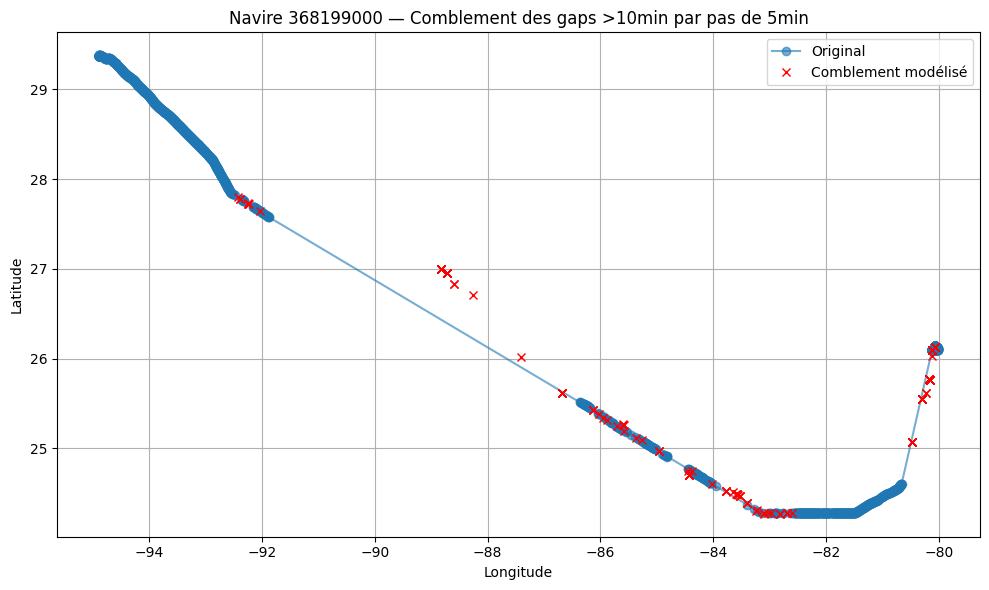

In [67]:
plt.figure(figsize=(10,6))
# trajectoire mesurée
plt.plot(df_boat['lon'], df_boat['lat'], 'o-', label='Original', alpha=0.6)
# prédictions comblées
plt.plot(filled_df['lon'], filled_df['lat'], 'x', label='Comblement modélisé', color='red')

plt.title(f"Navire {mmsi_example} — Comblement des gaps >10min par pas de 5min")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()